# Домашнее задание "Модели ARIMA"
Выберите ряд из первого задания и постройте его модель ARIMA. 

Дополнительное задание: попробуйте спрогнозировать график классическим ML.

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [3]:
df = pd.read_csv("D:/Netology/Python/Data_Science/Time_Series/1_Знакомство с временными рядами/Series/weekly-closings-of-the-dowjones-.csv")
df.head()

,Week,Close
0,1971-W27,890.19
1,1971-W28,901.80
2,1971-W29,888.51
3,1971-W30,887.78
4,1971-W31,858.43


C:\Users\ED-PC\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ED-PC\anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:218: RuntimeWarning: divide by zero encountered in true_divide
  loglike, sigma2 = kalman_loglike.kalman_loglike_double(
C:\Users\ED-PC\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\ED-PC\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\ED-PC\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\ED-PC\anaconda3\li

aic: 1416.27670 | order: (2, 2, 3)
Results of Dickey-Fuller Test:
Test Statistic                -1.184571e+01
p-value                        7.408149e-22
#Lags Used                     0.000000e+00
Number of Observations Used    1.590000e+02
Critical Value (1%)           -3.472161e+00
Critical Value (5%)           -2.879895e+00
Critical Value (10%)          -2.576557e+00
dtype: float64


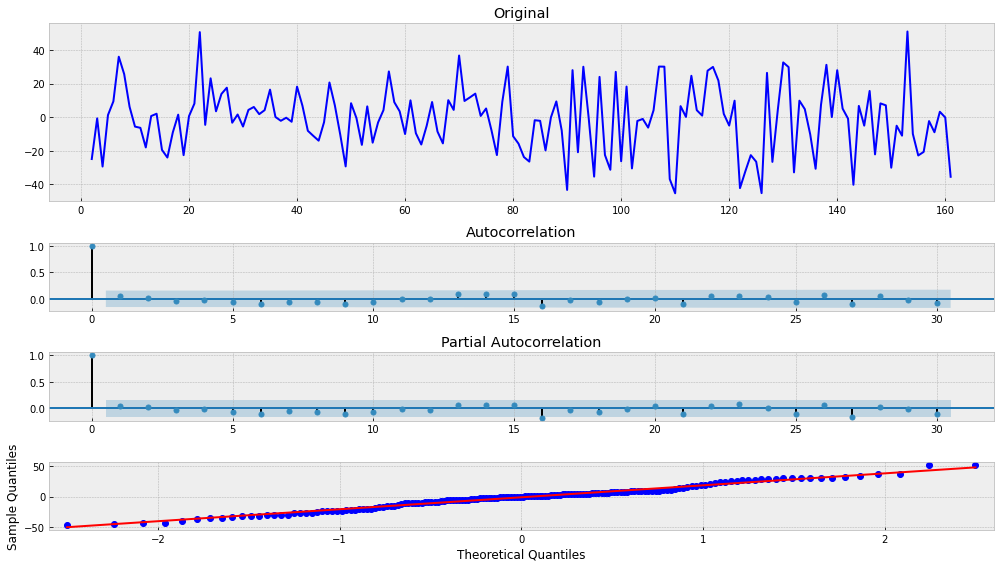

In [4]:
series = df['Close']

best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

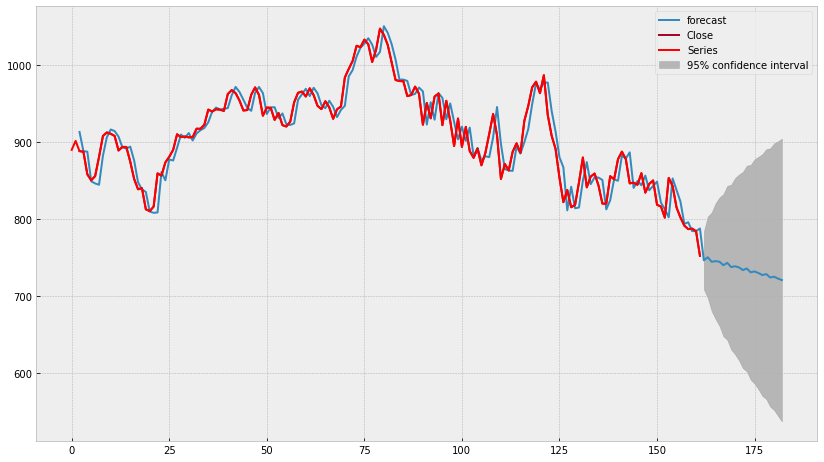

In [5]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(2, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

In [6]:
# добавляем день недели, чтобы преобразовать в формат timestamp
df['Week'] = df.Week + '-0'
df['Timestamp'] = pd.to_datetime(df.Week, format='%Y-W%U-%w')

In [7]:
# нагенерируем фичей, добавим месяц год и номер недели
df['month'] = df['Timestamp'].dt.month
df['year'] = df['Timestamp'].dt.year
df['num_week'] = df['Timestamp'].dt.isocalendar().week
df.head()

,Week,Close,Timestamp,month,year,num_week
0,1971-W27-0,890.19,1971-07-04,7,1971,26
1,1971-W28-0,901.80,1971-07-11,7,1971,27
2,1971-W29-0,888.51,1971-07-18,7,1971,28
3,1971-W30-0,887.78,1971-07-25,7,1971,29
4,1971-W31-0,858.43,1971-08-01,8,1971,30


In [8]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data['Close'].shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Week", "Timestamp"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Close"], axis=1)
    y_train = data.loc[:test_index]["Close"]
    X_test = data.loc[test_index:].drop(["Close"], axis=1)
    y_test = data.loc[test_index:]["Close"]
    
    return X_train, X_test, y_train, y_test

In [9]:
X_train, X_test, y_train, y_test = prepareData(df, lag_start=1, lag_end=30, test_size=0.3)
X_train

,month,year,num_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29
0,1,1972,3,906.68,910.37,890.20,881.17,873.80,856.75,859.59,...,912.75,908.15,880.91,856.02,850.61,858.43,887.78,888.51,901.80,890.19
1,1,1972,4,907.44,906.68,910.37,890.20,881.17,873.80,856.75,...,911.00,912.75,908.15,880.91,856.02,850.61,858.43,887.78,888.51,901.80
2,2,1972,5,906.38,907.44,906.68,910.37,890.20,881.17,873.80,...,908.22,911.00,912.75,908.15,880.91,856.02,850.61,858.43,887.78,888.51
3,2,1972,6,906.68,906.38,907.44,906.68,910.37,890.20,881.17,...,889.31,908.22,911.00,912.75,908.15,880.91,856.02,850.61,858.43,887.78
4,2,1972,7,917.59,906.68,906.38,907.44,906.68,910.37,890.20,...,893.98,889.31,908.22,911.00,912.75,908.15,880.91,856.02,850.61,858.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,3,1974,9,820.32,820.40,843.94,859.39,855.47,841.48,880.23,...,971.25,947.10,927.90,886.36,898.63,887.57,863.49,871.84,852.38,908.87
110,3,1974,10,855.99,820.32,820.40,843.94,859.39,855.47,841.48,...,978.63,971.25,947.10,927.90,886.36,898.63,887.57,863.49,871.84,852.38
111,3,1974,11,851.92,855.99,820.32,820.40,843.94,859.39,855.47,...,963.73,978.63,971.25,947.10,927.90,886.36,898.63,887.57,863.49,871.84
112,3,1974,12,878.05,851.92,855.99,820.32,820.40,843.94,859.39,...,987.06,963.73,978.63,971.25,947.10,927.90,886.36,898.63,887.57,863.49


RMSE: 26.64131259093396


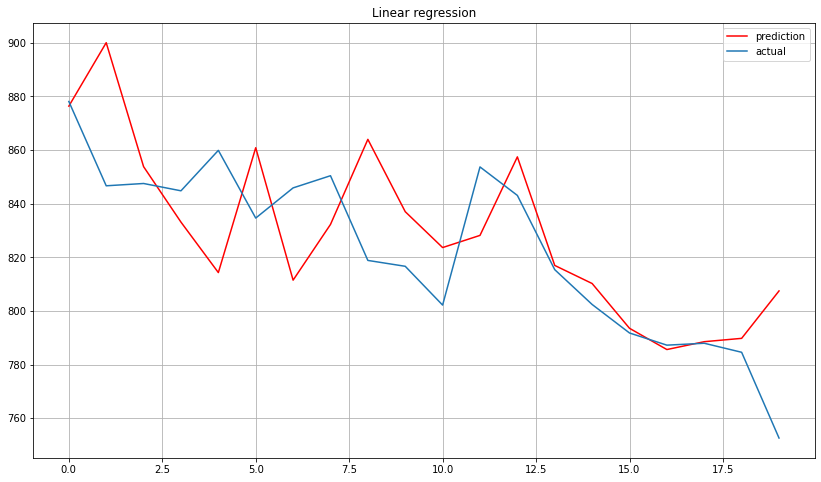

In [10]:
from sklearn.linear_model import LinearRegression
from math import sqrt

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
rms = sqrt(mean_squared_error(prediction, y_test.values))
print(f'RMSE: {rms}')
plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);